In [32]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl

In [33]:
plt.rc ('font', size = 10) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 10) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 10) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 20) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 10) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 10) #Schriftgröße der Legende

In [34]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break

FitFunktionen

In [35]:
def gaus1fit(von,bis,path,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],yerr=data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]), out_gaus




def gaus2fit(von,bis,path,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1,min=0)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],yerr=data[2,vonarr:bisarr],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='--',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01), out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus

Daten einlesen und Standartfehler as Fehler der Counts festlegen

<ErrorbarContainer object of 3 artists>

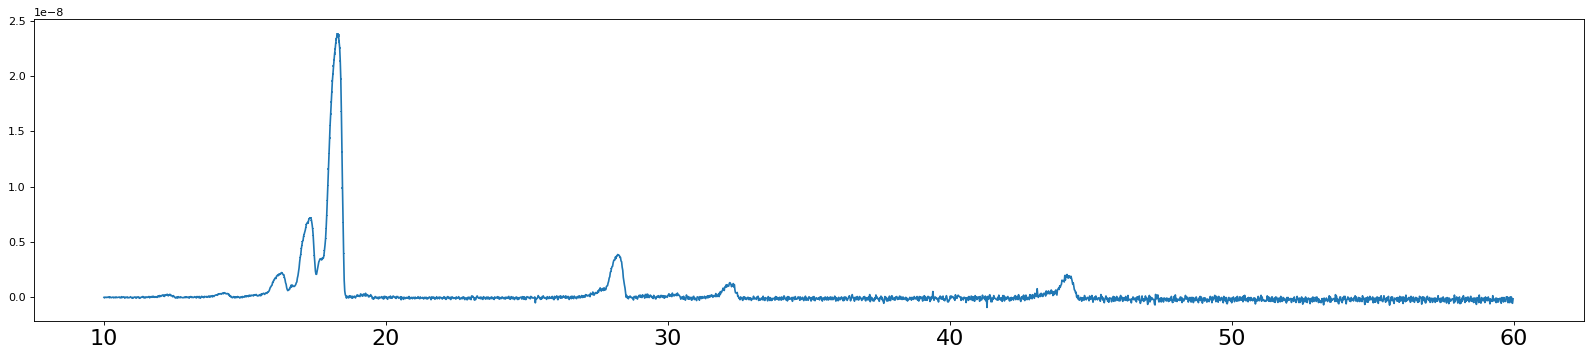

In [36]:

with open('Data/Restgas_3.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((2,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])*0.005
data = np.vstack([data,err])

v = pos(10)
b = pos(60)

for i in range(len(data[1])):
    data[1,i] = data[1,i]*data[0,i]/28
    data[2,i] = data[2,i]*data[0,i]/28

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],yerr=data[2,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 30
    # variables        = 3
    chi-square         = 450471.873
    reduced chi-square = 16684.1435
    Akaike info crit   = 294.505606
    Bayesian info crit = 298.709198
[[Variables]]
    amplitude:  3.8265e-11 +/- 6.1096e-12 (15.97%) (init = 1.129117e-10)
    center:     12.2061380 +/- 0.01511832 (0.12%) (init = 12.22333)
    sigma:      0.12520058 +/- 0.01187801 (9.49%) (init = 0.16)
    fwhm:       0.29482483 +/- 0.02797057 (9.49%) == '2.3548200*sigma'
    height:     1.2193e-10 +/- 2.5769e-11 (21.13%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.336
    C(amplitude, center) = 0.135


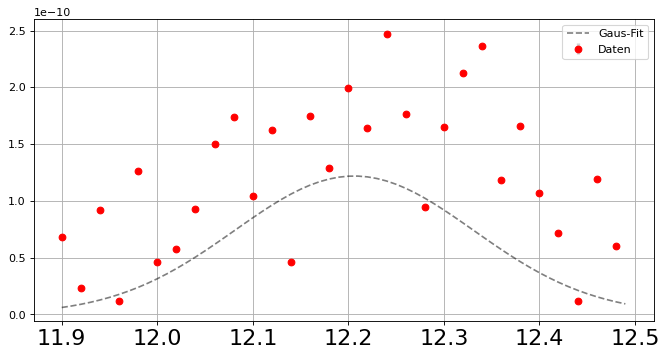

In [37]:
p12 = gaus1fit(11.9,12.5,'Restgas_3_12.2')



[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 32
    # variables        = 3
    chi-square         = 100251.339
    reduced chi-square = 3456.94273
    Akaike info crit   = 263.590394
    Bayesian info crit = 267.987601
[[Variables]]
    amplitude:  1.4453e-10 +/- 8.0041e-12 (5.54%) (init = 2.0625e-10)
    center:     14.2074752 +/- 0.00884799 (0.06%) (init = 14.231)
    sigma:      0.16719604 +/- 0.00801760 (4.80%) (init = 0.2)
    fwhm:       0.39371657 +/- 0.01888000 (4.80%) == '2.3548200*sigma'
    height:     3.4485e-10 +/- 2.6457e-11 (7.67%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.278
    C(amplitude, center) = 0.153


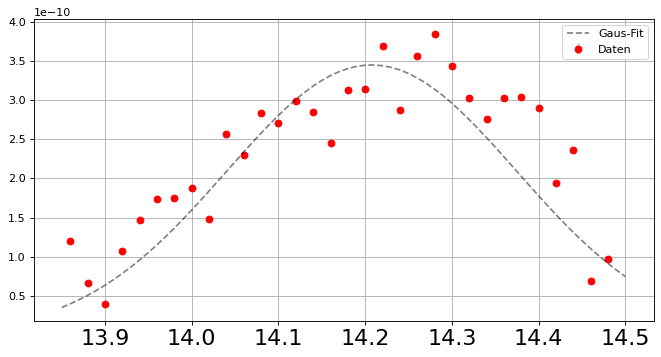

In [38]:
p14 = gaus1fit(13.85,14.5,'Restgas_3_14.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 37
    # variables        = 3
    chi-square         = 14458.6784
    reduced chi-square = 425.255246
    Akaike info crit   = 226.820891
    Bayesian info crit = 231.653644
[[Variables]]
    amplitude:  1.2081e-09 +/- 2.3748e-11 (1.97%) (init = 1.30264e-09)
    center:     16.2170945 +/- 0.00560830 (0.03%) (init = 16.21)
    sigma:      0.22743624 +/- 0.00478589 (2.10%) (init = 0.23)
    fwhm:       0.53557140 +/- 0.01126990 (2.10%) == '2.3548200*sigma'
    height:     2.1191e-09 +/- 5.1055e-11 (2.41%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.674
    C(amplitude, center) = 0.497
    C(amplitude, sigma)  = 0.301


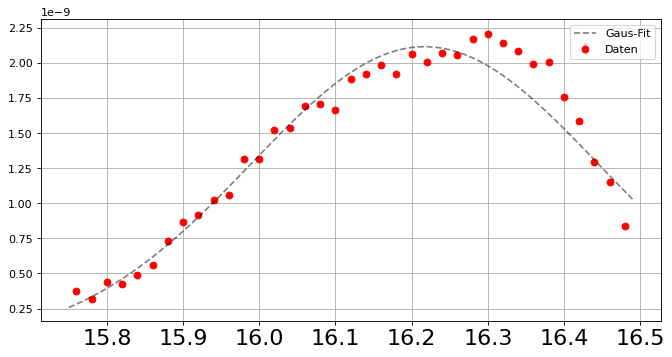

In [39]:
p16 = gaus1fit(15.75,16.5,'Restgas_3_16.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 35
    # variables        = 3
    chi-square         = 8668.88381
    reduced chi-square = 270.902619
    Akaike info crit   = 198.925154
    Bayesian info crit = 203.591198
[[Variables]]
    amplitude:  3.9264e-09 +/- 6.4206e-11 (1.64%) (init = 4.000013e-09)
    center:     17.2310004 +/- 0.00457651 (0.03%) (init = 17.22)
    sigma:      0.22010920 +/- 0.00391405 (1.78%) (init = 0.22)
    fwhm:       0.51831754 +/- 0.00921689 (1.78%) == '2.3548200*sigma'
    height:     7.1165e-09 +/- 1.3910e-10 (1.95%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.681
    C(amplitude, center) = 0.521
    C(amplitude, sigma)  = 0.347


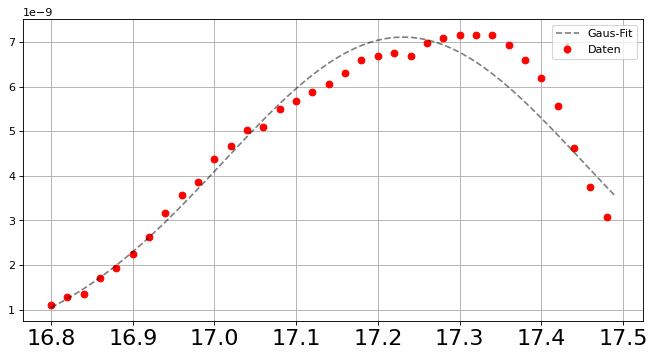

In [40]:
p17 = gaus1fit(16.8,17.5,'Restgas_3_17.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 38
    # variables        = 3
    chi-square         = 218071.762
    reduced chi-square = 6230.62178
    Akaike info crit   = 334.889746
    Bayesian info crit = 339.802504
[[Variables]]
    amplitude:  9.6763e-09 +/- 7.2922e-10 (7.54%) (init = 1.605373e-08)
    center:     18.1443946 +/- 0.00930131 (0.05%) (init = 18.21)
    sigma:      0.15618131 +/- 0.00579047 (3.71%) (init = 0.23)
    fwhm:       0.36777886 +/- 0.01363552 (3.71%) == '2.3548200*sigma'
    height:     2.4717e-08 +/- 2.3787e-09 (9.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.484
    C(amplitude, sigma)  = -0.395
    C(amplitude, center) = 0.221


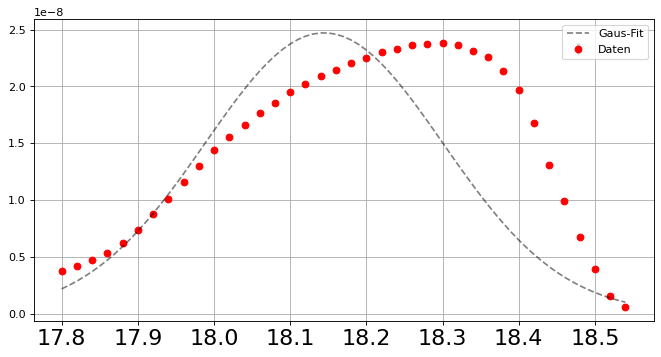

In [41]:
p18 = gaus1fit(17.8,18.55,'Restgas_3_18.2')#,override=True,m1=18.21,m1min=18.15,m1max=18.5,s1=0.23,scale1=8.940706e-10,m2=17.61,m2min=17.6,m2max=17.8,s2=0.5,scale2=2.682212e-10)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 40
    # variables        = 3
    chi-square         = 58613.9730
    reduced chi-square = 1584.16143
    Akaike info crit   = 297.593958
    Bayesian info crit = 302.660596
[[Variables]]
    amplitude:  1.8894e-09 +/- 6.3956e-11 (3.38%) (init = 2.152186e-09)
    center:     28.1639881 +/- 0.00683758 (0.02%) (init = 28.18)
    sigma:      0.21051957 +/- 0.00652113 (3.10%) (init = 0.22)
    fwhm:       0.49573570 +/- 0.01535610 (3.10%) == '2.3548200*sigma'
    height:     3.5806e-09 +/- 1.7370e-10 (4.85%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.396
    C(amplitude, center) = 0.227
    C(amplitude, sigma)  = -0.118


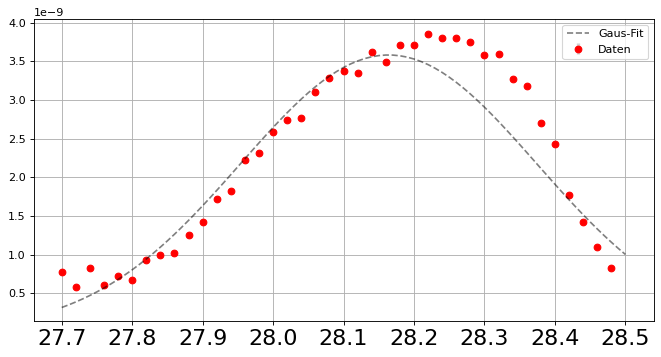

In [42]:
p28 = gaus1fit(27.7,28.5,'Restgas_3_28.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 35
    # variables        = 3
    chi-square         = 241105.281
    reduced chi-square = 7534.54003
    Akaike info crit   = 315.317432
    Bayesian info crit = 319.983476
[[Variables]]
    amplitude:  4.5913e-10 +/- 3.9460e-11 (8.59%) (init = 7.605058e-10)
    center:     32.1694846 +/- 0.00824694 (0.03%) (init = 32.168)
    sigma:      0.13632851 +/- 0.00500837 (3.67%) (init = 0.2)
    fwhm:       0.32102909 +/- 0.01179382 (3.67%) == '2.3548200*sigma'
    height:     1.3436e-09 +/- 1.4022e-10 (10.44%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.341
    C(center, sigma)    = 0.136


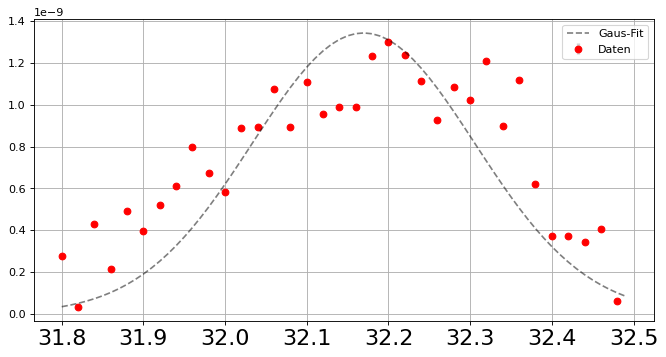

In [43]:
p32 = gaus1fit(31.8,32.5,'Restgas_3_32.2')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 45
    # variables        = 3
    chi-square         = 261618.043
    reduced chi-square = 6229.00101
    Akaike info crit   = 396.059027
    Bayesian info crit = 401.479014
[[Variables]]
    amplitude:  8.9965e-10 +/- 6.1701e-11 (6.86%) (init = 1.202533e-09)
    center:     44.1517932 +/- 0.01192651 (0.03%) (init = 44.17)
    sigma:      0.20104738 +/- 0.01037332 (5.16%) (init = 0.21)
    fwhm:       0.47343038 +/- 0.02442731 (5.16%) == '2.3548200*sigma'
    height:     1.7852e-09 +/- 1.7194e-10 (9.63%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.431
    C(amplitude, sigma)  = -0.270
    C(amplitude, center) = 0.116


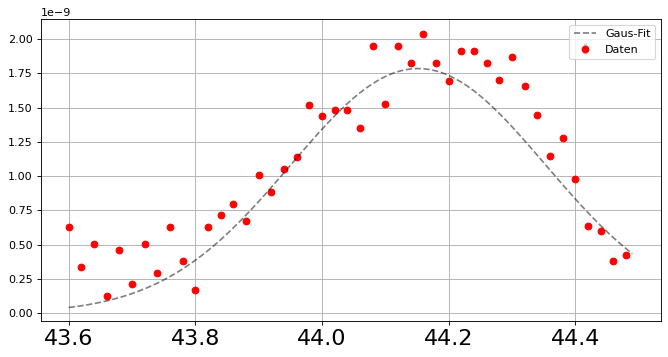

In [44]:
p44 = gaus1fit(43.6,44.5,'Restgas_3_44.2')

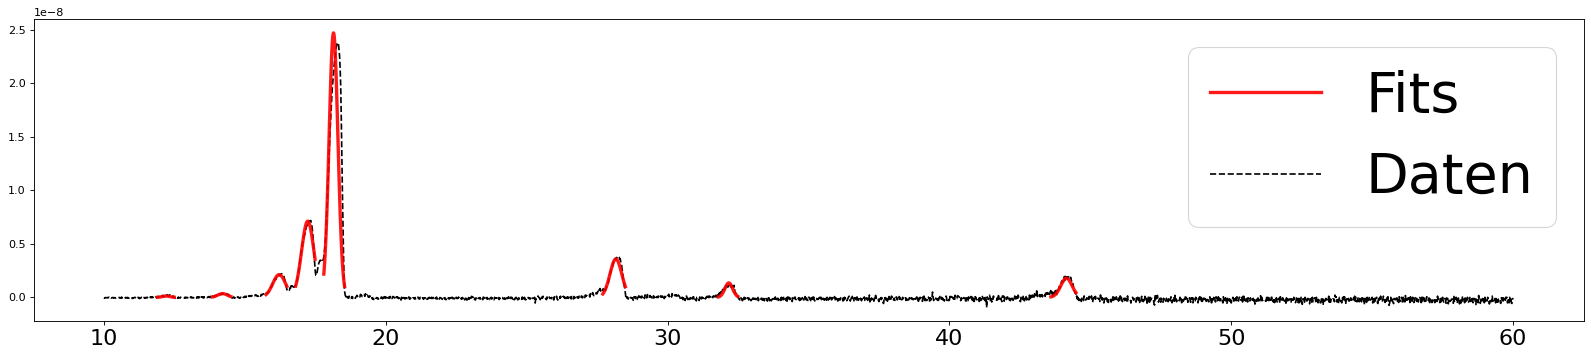

In [47]:
fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')
plt.plot(p12[0][0],p12[0][1],zorder=10,label='Fits',color='r',alpha=0.9,linewidth=3)
plt.plot(p14[0][0],p14[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p16[0][0],p16[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p17[0][0],p17[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p18[0][0],p18[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p28[0][0],p28[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p32[0][0],p32[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)
plt.plot(p44[0][0],p44[0][1],zorder=10,color='r',alpha=0.9,linewidth=3)


plt.legend(fontsize=50)

In [54]:
a12 = ufloat(p12[1].params['amplitude'].value,p12[1].params['amplitude'].stderr)
a14 = ufloat(p14[1].params['amplitude'].value,p14[1].params['amplitude'].stderr)
a16 = ufloat(p16[1].params['amplitude'].value,p16[1].params['amplitude'].stderr)
a17 = ufloat(p17[1].params['amplitude'].value,p17[1].params['amplitude'].stderr)
a18 = ufloat(p18[1].params['amplitude'].value,p18[1].params['amplitude'].stderr)
a28 = ufloat(p28[1].params['amplitude'].value,p28[1].params['amplitude'].stderr)
a32 = ufloat(p32[1].params['amplitude'].value,p32[1].params['amplitude'].stderr)
a44 = ufloat(p44[1].params['amplitude'].value,p44[1].params['amplitude'].stderr)

print(a12+a14+a16+a17+a18+a28+a32+a44)

(1.82+/-0.07)e-08


In [55]:
sum=0
for i in data[1]:
    sum+=i
print(sum)

7.822837212310732e-07


In [49]:
print(p12[1].fit_report())
print(p14[1].fit_report())
print(p16[1].fit_report())
print(p17[1].fit_report())
print(p18[1].fit_report())
print(p28[1].fit_report())
print(p32[1].fit_report())
print(p44[1].fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 30
    # variables        = 3
    chi-square         = 450471.873
    reduced chi-square = 16684.1435
    Akaike info crit   = 294.505606
    Bayesian info crit = 298.709198
[[Variables]]
    amplitude:  3.8265e-11 +/- 6.1096e-12 (15.97%) (init = 1.129117e-10)
    center:     12.2061380 +/- 0.01511832 (0.12%) (init = 12.22333)
    sigma:      0.12520058 +/- 0.01187801 (9.49%) (init = 0.16)
    fwhm:       0.29482483 +/- 0.02797057 (9.49%) == '2.3548200*sigma'
    height:     1.2193e-10 +/- 2.5769e-11 (21.13%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = -0.336
    C(amplitude, center) = 0.135
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 32
    # variables        = 3
    chi-square      